# A stock market analysis using SARIMAX and Recurrent Neural Networks as a mean of predicting and comparing NASDAQ(mean), AAPL and GOOGL stocks.

## Contents: 
- [Slides](https://docs.google.com/presentation/d/1bcpBwSQs8O0uMNNQ-zIIhgVuiHhXzJw4Uov83yqqQ6Y/edit?usp=sharing)
- [Problem Statement](#Problem-Statement)
- [Load Libraries](#Load-Libraries)
- [Data Pull | Data Store | Data Call](#Data-Pull-|-Data-Store-|-Data-Call)
- [Feature Engineering | Pre-Processing | Modeling](#Feature-Engineering-|-Pre-Processing-|-Modeling)
    - [NASDAQ](#NASDAQ)
    - [AAPL](#AAPL)
    - [GOOGL](#GOOGL)
- [Recurrent Neural Networks](#Recurrent-Neural-Networks)
    - [RNN-NASDAQ](#RNN-NASDAQ)
    - [RNN-AAPL](#RNN---AAPL)
    - [RNN-GOOGL](#RNN-GOOGL)
- [Clustering](#Clustering)
- [Executive Summary](#Executive-Summary)
- [Limitations](#Limitations)
- [Citations](#Citations)

## [Slides](https://docs.google.com/presentation/d/1bcpBwSQs8O0uMNNQ-zIIhgVuiHhXzJw4Uov83yqqQ6Y/edit?usp=sharing)

## [Problem Statement](#Contents:)

While most of us wish to make an easy buck, many do not know where to start. We took the liberty to address this issue by attempting to predict the stock market. Specifically, comparing the aggregate mean of the NASDAQ to two specific big players in the market, AAPL and GOOGL. Collecting stock market data from IEX cloud, we were able to retrieve data over 2 months and 5 years.

Using time series models, RNN and SARIMAX, we will come up with a model that attempts to trace the market. Our goal is to determine the limit to predicting the market in this way and to determine if a more volatile stock like AAPL is predicted better or worse than GOOGL and so on.

## [Load Libraries](#Contents:)

Loading libraries in environment and sub functions for later use.

In [296]:
import itertools
import time
import json
import warnings
warnings.filterwarnings("ignore")
import numpy                            as np
import pandas                           as pd
import seaborn                          as sns

# Import statsmodels functions
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api                  as sm
from statsmodels.tsa.stattools          import adfuller
from statsmodels.graphics.tsaplots      import plot_acf, plot_pacf
from sklearn.metrics                    import r2_score, mean_absolute_error,mean_squared_error, roc_curve, accuracy_score,confusion_matrix, f1_score, make_scorer, silhouette_score
from sklearn.preprocessing              import PolynomialFeatures, StandardScaler
from sklearn.model_selection            import train_test_split
from sklearn.cluster                    import KMeans

#Import iexfinance functions    
from iexfinance.stocks                  import get_historical_data,get_historical_intraday,Stock
from iexfinance.refdata                 import get_symbols
from iexfinance.altdata                 import get_social_sentiment

# Import matplotlib functions
import matplotlib.pyplot                as plt
%matplotlib inline

# Import keras functions
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.preprocessing.sequence import TimeseriesGenerator

# Import talib functions
import talib

# Import datetime functions
from datetime                           import datetime

## [Data Pull | Data Store | Data Call](#Contents:)

In this section we call the API key which can be made for free at IEX.com One can collect about half of the data we used per month. So this will effectively be the largest bottle neck. Though it does not take very long, without a subscription one is limited to a certain amount of requests. 5 years of data consumes around 1300 requests. Free accounts provide 500,000 requests per month. This is well over the < 700 symbols we have to work with in the Technology sector of the NASDAQ. Notice that the API Key is stored in an external file as to not compromise security.

In [297]:
## Read API key from text file
# token_api = open('/Users/hadimorrow/Desktop/General Assembly/Capstone 2/API IEX CAPSTONE GA DSI 8.txt','r')
# token_api_contents = token_api.read()
# token_api.close()
# df = get_symbols(output_format = 'pandas', token = token_api_contents)
## Read symbols saved for NASDAQ tech industry 
# Tickers = pd.read_csv('../data/companylist.csv')['Symbol']
# start_predictant = datetime(2014, 7, 17)
# end_predictant = datetime(2019, 7, 21)
# key = token_api_contents

Below we perform the actual API requests for each ticker in the Tickers list found at: https://www.nasdaq.com/screening/companies-by-industry.aspx?industry=Technology

In [298]:
# # # This function takes any tickers | symbols and creates a list of historical values with a column of the ticker | symbol
# # # Sleep function so we do not pull too fast and get an error from client side.
# # def Data(start,end):
# #     df = []
# #     error = []
# #     for ticker in Tickers:
# #         try:
# #             df_temp = get_historical_data(ticker, start, end, token=key, output_format = 'pandas')
# #             df_temp['ticker'] = ticker
# #             df.append(df_temp)
# #             time.sleep(.01)
# #         except:
# #             error.append(ticker)
# #     return df
# Data = Data(start,end)
# Data.to_csv('../data/data_5yrs_7_26.csv')

After all of that work we want to make sure we saved our work in a safe place. Here we call on that data.

In [299]:
# Reading stored data and tickers
df = pd.read_csv('../data/data_5yrs_7_26.csv')
Tickers = pd.read_csv('../data/companylist.csv')['Symbol']

## [Feature Engineering | Pre-Processing | Modeling](#Contents:)
### [NASDAQ](#Contents:)

In the cells to follow we initialize a function that interprets the adfuller statistic and a CCI function to be used later in feature engineering. Second we find only symbols (companies) for which we have 5 years of data for. In other words not new to the NASDAQ. Then we format the time starting 7/21/2014 such that the periods are daily with monthly frequencies. Finally for Market data or NASDAQ we find the mean of all of those companies per date and use day as a frequency measure.

In [359]:
# Function used to interpret adfuller Test Statistic and p-value
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

# Commodity Channel Index function
def CCI(df, n):
    PP = (df['high'] + df['low'] + df['close']) / 3
    CCI = pd.Series((PP - PP.rolling(n).mean()) / PP.rolling(n).std() / 0.015, name = 'CCI' + str(n))
    return CCI

# Confusion matrix function spits out TN, FP, FN, TP, Accuracy Rate, Misclassification Rate, Sensivitiy, Specificity and Precision
def metrics(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    print(f'True Positive: {TP}')
    print(f'True Negative: {TN}')
    print(f'False Positive: {FP}')
    print(f'False Negative: {FN}')
    print(f'Accuracy Rate: {(TP+TN)/(TP+TN+FP+FN)}')
    print(f'Misclassification Rate: {(1-((TP+TN)/(TP+TN+FP+FN)))}')
    print(f'Sensivitiy: {(TP)/(TP+FN)}')
    print(f'Specificity: {(TN)/(TN+FP)}') 
    print(f'Precision: {(TP)/(TP+FP)}') 
    print(confusion_matrix(y_true,y_pred))
    
# Function to get accuracy rate    
def metricsacc(y_true,y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true,y_pred).ravel()
    return (TP+TN)/(TP+TN+FP+FN)

# Normalizing function
def stdard(df):
    for i in range(df.shape[1]):
        df = pd.DataFrame(df)
        mean = np.mean(df.iloc[:,i])
        standard = np.std(df.iloc[:,i])
        df.iloc[:,i] = ((df.iloc[:,i]-mean)/standard)
    return df.dropna(axis = 1).values

# Starting SARIMAX MSE Search function
def SARIMAX_MSE_Search(y_train,X_train):
    # Starting MSE and (P, D, Q, S).
    best_mse = 99 * (10 ** 16)
    final_P = 0
    final_D = 0
    final_Q = 0
    final_S = 0

    for P in range(3):
        for Q in range(3):
            for D in range(3):
                for S in range(0,20,2):
                    try:
                        print(f'Attempting to fit SARIMAX(0,2,1)x({P},{D},{Q},{S})')
                        # Instantiate SARIMAX model.
                        sarimax = SARIMAX(endog = y_train,
                                         order = (0, 2, 1),              # (p, d, q)
                                         seasonal_order = (P, D, Q, S),  # (P, D, Q, S)
                                         exog = X_train.dropna()) 

                        # Fit SARIMAX model.
                        model = sarimax.fit()

                        # Generate predictions based on test set.
                        preds = model.predict(start=datetime(2016,4,18),
                                              end=datetime(2018,1,3),
                                              exog=X_test.dropna())

                        # Evaluate predictions.
                        print(f'The MSE for (0, 2, 1)x({P},{D},{Q},{S}) is: {mean_squared_error(y_test, preds[:len(y_test)])}')

                        # Save for final report.
                        if best_mse > mean_squared_error(y_test, preds[:len(y_test)]):
                            best_mse = mean_squared_error(y_test, preds[:len(y_test)])
                            final_P = P
                            final_D = D
                            final_Q = Q
                            final_S = S

                    except:
                        pass

    print(f'Our model that minimizes MSE on the testing data is the SARIMAX(0, 2, 1)x({final_P},{final_D},{final_Q},{final_S}).')
    print(f'This model has an MSE of {best_mse}.')
    return [best_mse ,final_P ,final_D ,final_Q ,final_S]

# Fit a SARIMA model and make plot of preds
def SARIMAX_Plot(y_train, y_test, X_train, X_test, P, D, Q, S, stock): # P, D, Q, S are integer inputs , stock is a string representing the stock name.
    sarima = SARIMAX(endog = y_train,
                     order = (0, 2, 1),              # (p, d, q)
                     seasonal_order = (P, D, Q, S), #(P, D, Q, S)
                     exog = X_train.dropna()) 
    # Fit SARIMA model.
    model = sarima.fit()

    # Generate predictions based on test set.
    # Plot data.
    plt.figure(figsize=(12,7))
    plt.plot(y_train, color = 'blue',label = ' True Train')
    plt.plot(y_test, color = 'orange',label = ' True Test',linewidth = 5)
    preds = model.predict(start=datetime(2017,4,26),
                          end=datetime(2018,1,3),
                          exog=X_test.dropna())
    plt.plot(preds, color = 'green',label = ' Predictions')
    plt.xlabel("$Date$", fontsize=18)
    plt.ylabel("$Price$", fontsize=18)
    plt.title(label = f'{stock} with SARIMAX(0, 2, 1) x ({P}, {D}, {Q}, {S}) Predictions', fontsize=16)
    plt.legend();
    plt.show();
    return preds

Key takeaway here is that given the adfuller test, we reject the null hypothesis that we need to difference and conclude that a significant difference does exist at the current state and thus stationarity exists already

In [360]:
# Formating NASDAQ symbol data with time frequency and consistent length 
Data = []
for tick in Tickers:
    temp = df[df['ticker']==tick]
    if temp.shape[0] == 1263: # Hard coding 1263 for 5 years worth of daily data 
        # Specify frequency for data (this will be relevant later)!
        temp.index = pd.date_range('7/21/2014', # start date is 7/21/2014
                               periods=len(temp.index), # we want one period per entry
                               freq='D') # frequency in days
        Data.append(temp)
Market = pd.DataFrame(pd.concat(Data)).sort_values(by = 'Unnamed: 0')
Market = Market.groupby(Market.index).mean()
Market.index = pd.date_range('7/21/2014', # start date is 7/21/2014
                               periods=len(Market.index), # we want one period per entry
                               freq='D') # frequency in days
# Run ADF test on original (non-differenced!) data.
adfuller(Market['close'])
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(Market['close']))

Test Statistic   -4.472181
p-value           0.000221
dtype: float64

Here we generate an acf plot. we see many statistically significant lags, what does the pacf show?

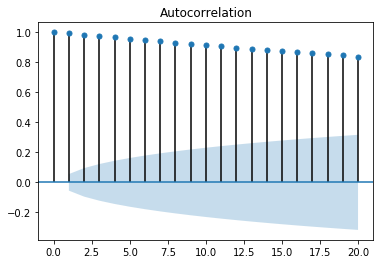

In [361]:
# Generate plot.
plot_acf(Market['close'].dropna(), lags=20);

The pacf plot shows two statistically significant lags though we could argue others as well.

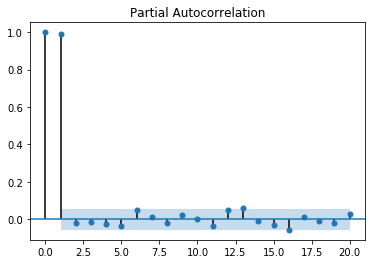

In [362]:
# Generate plot.
plot_pacf(Market['close'].dropna(), lags=20);

Below we perform three critical steps. First we drop Null values, next we create a train test split at 20% of the test size with **shuffle = False**  and finally run a long SARIMAX model where we overwrite the values of (P, D, Q, S) and MSE when MSE is lower than the previous run, effectively automating a difficult process.

In [363]:
# df with na dropped
Market['close'].dropna(inplace = True)
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(Market[['close']].iloc[:,-1:],
                                                    Market[['close']].iloc[:,-1:],
                                                    test_size = 0.2,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

# Starting SARIMAX MSE Search
SARIMAX_MSE_Search(y_train, X_train)

###### Okay so how did we do?
Fitting a SARIMA(0, 2, 1) x (0, 2, 0, 2) model where green are the predictions and blue and orange are the train and test respectively, we get a horrible fit. Clearly something was not performed correctly. Right? Well lets see, let us try Apple and Google and see how they do. They are single stocks and maybe we can get more meaning out of the stocks rather than the composite.  

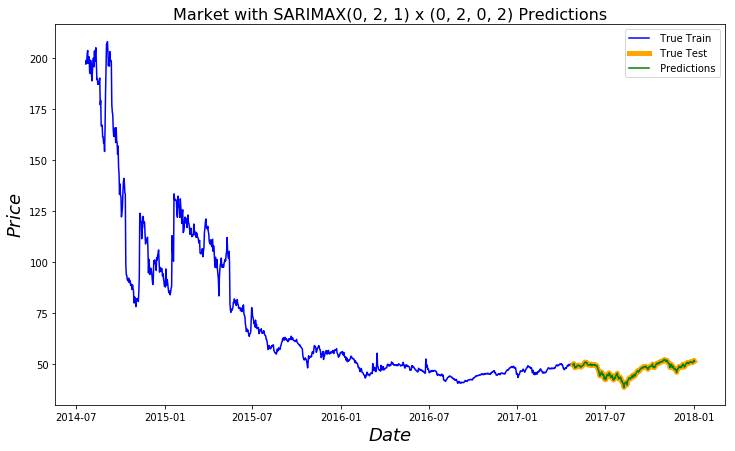

In [364]:
# df with na dropped
#Market['close'].dropna(inplace = True)
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(Market[['close']],
                                                    Market[['close']],
                                                    test_size = 0.2,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!


preds = SARIMAX_Plot(y_train, y_test, X_train, X_test, 0, 2, 0, 2, 'Market')

Concluding that the model is way overfit and thus will underperform in a real prediction scenario

In [365]:
print(f'The Mean Square Error for the train is: {mean_squared_error(y_train[-len(preds):], preds)}')
print(f'The Mean Square Error for the test is: {mean_squared_error(y_test, preds[:len(y_test)])}')

The Mean Square Error for the train is: 18.48759728063828
The Mean Square Error for the test is: 7.060834119001905e-18


Bellow is a better metric, the root mean squared error (RMSE) which shows how much the model is off by in dollars. As an approximate measure. Over fitting is a real issue here. 14 Dollar misrepresentation on train versus 85 Dollars for test is rather large.

In [366]:
print(f'The Root Mean Square Error for the train is: {(mean_squared_error(y_train[-len(preds):], preds)**.5)}')
print(f'The Root Mean Square Error for the test is: {(mean_squared_error(y_test, preds[:len(y_test)])**.5)}')

The Root Mean Square Error for the train is: 4.299720604950777
The Root Mean Square Error for the test is: 2.657223008895171e-09


## [AAPL](#Contents:)

In this section we look at Apple also known as AAPL. We frequency the data to daily run the adfuller test and interpret it. We find that in this case there is no stationarity and thus we must difference once to see if the null hypothesis can be rejected or not. After differencing we find that it is the case and that the data is stationary. The acf shows one significant lag at and 2 minor ones at 6 and 16 trading days. The same is true for the pacf.

In [351]:
# Ok so here we go again, we have to first find the AAPL ticker data and apply the correct frequency or the SARAMAX model will not understand the index.
AAPL = pd.DataFrame(pd.concat(Data)).sort_values(by = 'Unnamed: 0')
AAPL = AAPL[AAPL['ticker']=='AAPL']
AAPL.index = pd.date_range('7/21/2014', # start date is 7/21/2014
                               periods=len(AAPL.index), # we want one period per entry
                               freq='D') # Daily frequency
AAPL = AAPL[['close']]
# Run ADF test on original (non-differenced!) data.
adfuller(AAPL['close'])
# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(AAPL['close']))

Test Statistic   -0.861240
p-value           0.800469
dtype: float64

In [352]:
# Run the ADF test on our once-differenced data.
interpret_dftest(adfuller(AAPL['close'].diff(1).dropna()))

Test Statistic   -1.196357e+01
p-value           4.049218e-22
dtype: float64

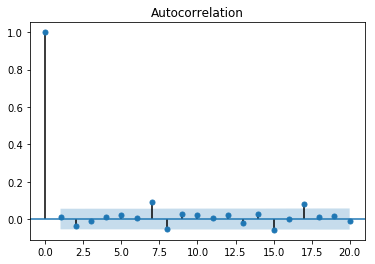

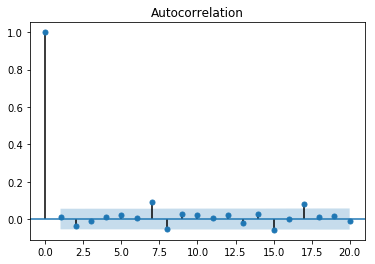

In [353]:
# Generate plot.
plot_acf(AAPL['close'].diff(1).dropna(), lags=20)

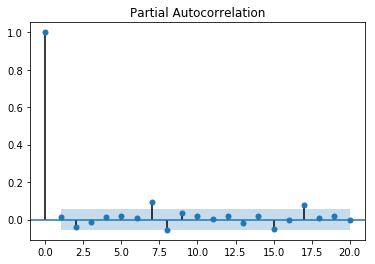

In [354]:
# Generate plot.
plot_pacf(AAPL['close'].diff(1).dropna(), lags=20);

In [355]:
# Putting together train test df
AAPL_train_test = pd.DataFrame({'lag_diff_diff_1':AAPL['close'].diff(1).shift(1)})
AAPL_train_test['close'] = AAPL['close']
AAPL_train_test.dropna(inplace = True)
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(AAPL_train_test.iloc[:,:-1],
                                                    AAPL_train_test.iloc[:,-1:],
                                                    test_size = 0.2,                                                    shuffle = False) # Shuffle = False is IMPORTANT!

SARIMAX_MSE_Search(y_train, X_train)

Ok, it is clear that here we did much better. Clearly this prediction is awful but at least we are pointing in the correct direction, more or less. Fitting a SARIMA(0, 2, 1) x (2, 2, 2, 12) model seems to be a good choice here with predictions as green, blue as train and orange as test. So what could have contributed to this feature in our predictions? One this is that the model gets more variance to shape the model itself. The model with NASDAQ is a mean of 600+ symbols. This could cause the model to accurately predict the large trend which has been declining however not sensitive to the incline toward the end of the data. Think big 18 wheeler down a mountain with no breaks, then think small SUV same issue, the SUV might be able to engine break and not cause a catastrophic failure but the 18 wheeler has passed that point of no return with its 40 tons of cargo.

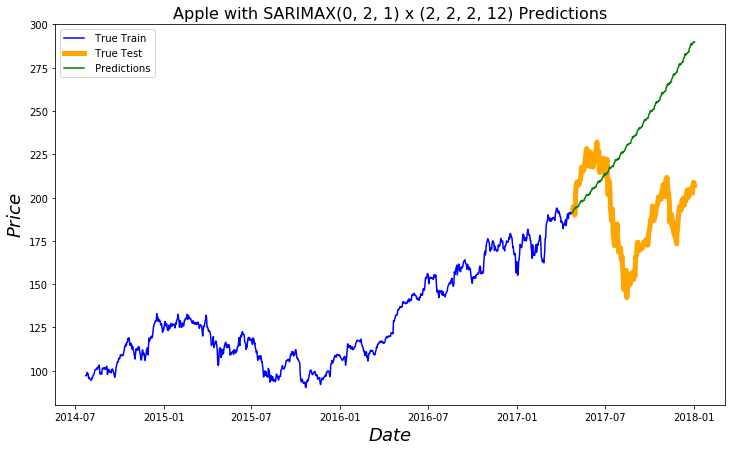

In [356]:
X_train, X_test, y_train, y_test = train_test_split(AAPL_train_test.iloc[:,:-1],
                                                    AAPL_train_test.iloc[:,-1:],
                                                    test_size = 0.2,                                                    shuffle = False) # Shuffle = False is IMPORTANT!

preds = SARIMAX_Plot(y_train, y_test, X_train, X_test, 2, 2, 2, 12, 'Apple')

Here we can see that we are getting **closer** according to the MSE

In [357]:
print(f'The Mean Square Error for the train is: {mean_squared_error(y_train[-len(preds):], preds)}')
print(f'The Mean Square Error for the test is: {mean_squared_error(y_test, preds[:len(y_test)])}')

The Mean Square Error for the train is: 4720.512901834118
The Mean Square Error for the test is: 3534.6106123659283


In fact we are getting **much closer** The difference here is slightly over 26 dollars which is the magnitude of the RMSE for the train set. Getting better, this bay be due to capturing less varience from other companies.

In [358]:
print(f'The Root Mean Square Error for the train is: {(mean_squared_error(y_train[-len(preds):], preds)**.5)}')
print(f'The Root Mean Square Error for the test is: {(mean_squared_error(y_test, preds[:len(y_test)])**.5)}')

The Root Mean Square Error for the train is: 68.70598883528362
The Root Mean Square Error for the test is: 59.452591300681995


## [GOOGL](#Contents:)

In [367]:
Google = pd.DataFrame(pd.concat(Data)).sort_values(by = 'Unnamed: 0')
Google = Google[Google['ticker']=='GOOGL']
Google.index = pd.date_range('7/21/2014', # start date is 7/21/2014
                               periods=len(Google.index), # we want one period per entry
                               freq='D') # frequency daily
Google = Google[['close']]

# Run ADF test on original (non-differenced!) data.
interpret_dftest(adfuller(Google['close']))

Test Statistic   -0.839195
p-value           0.807337
dtype: float64

In [368]:
# Run the ADF test on our once-differenced data.
interpret_dftest(adfuller(Google['close'].diff(1).dropna()))

Test Statistic   -1.311434e+01
p-value           1.610631e-24
dtype: float64

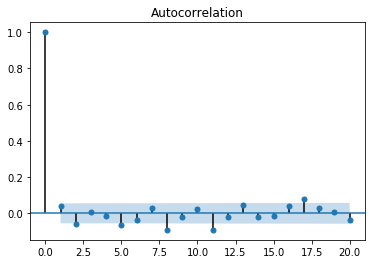

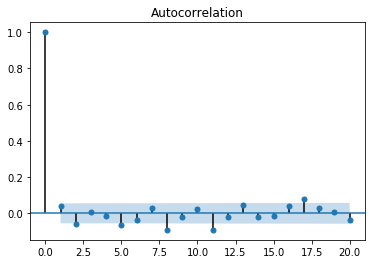

In [369]:
# Generate plot.
plot_acf(Google['close'].diff(1).dropna(), lags=20)

In [370]:
Google = pd.DataFrame(pd.concat(Data)).sort_values(by = 'Unnamed: 0')
Google = Google[Google['ticker']=='GOOGL']
Google.index = pd.date_range('7/21/2014', # start date is 7/21/2014
                               periods=len(Google.index), # we want one period per entry
                               freq='D') # frequency daily
Google = Google[['close']]

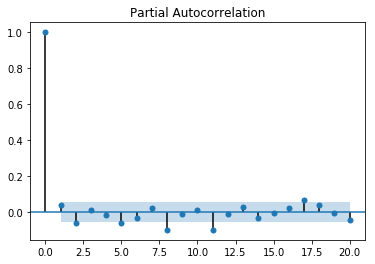

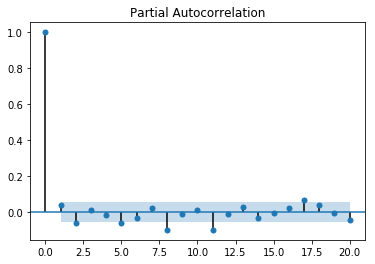

In [371]:
# Generate plot.
plot_pacf(Google['close'].diff(1).dropna(), lags=20)

In [372]:
# Run ADF test on original (non-differenced!) data.
adfuller(Google['close'])

(-0.8391948642547937,
 0.8073369630809601,
 11,
 1251,
 {'1%': -3.4355880246374304,
  '5%': -2.8638531175675896,
  '10%': -2.568001531098063},
 9912.022299731852)

In [373]:
# GOOGL df
Google_train_test = pd.DataFrame({'lag_diff_1':Google['close'].diff(1).shift(1)})
Google_train_test['close'] = Google['close']
Google_train_test.dropna(inplace = True)

# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(Google_train_test.iloc[:,:-1],
                                                    Google_train_test.iloc[:,-1:],
                                                    test_size = 0.2,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

# Starting SARIMAX MSE Search
SARIMAX_MSE_Search(y_train, X_train)

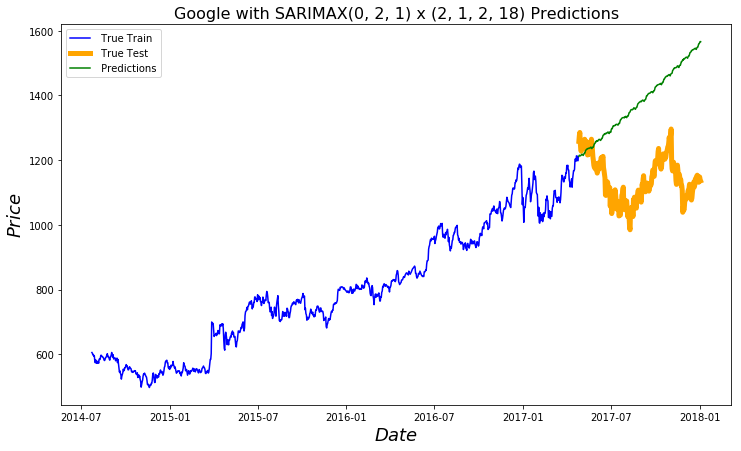

In [374]:
preds = SARIMAX_Plot(y_train, y_test, X_train, X_test, 2, 1, 2, 18, 'Google')

The MSE here is larger but this is due to the large price of the stock

In [375]:
print(f'The Mean Square Error for the train is: {mean_squared_error(y_train[-len(preds):], preds)}')
print(f'The Mean Square Error for the test is: {mean_squared_error(y_test, preds[:len(y_test)])}')

The Mean Square Error for the train is: 108233.61393462881
The Mean Square Error for the test is: 73894.61339885385


The RMSE here is much worse but this is due to the large stock value, however even so, it is several times larger than the RMSE for the train and thus not as good of a model as Apples' stock model

In [376]:
print(f'The Root Mean Square Error for the train is: {(mean_squared_error(y_train[-len(preds):], preds)**.5)}')
print(f'The Root Mean Square Error for the test is: {(mean_squared_error(y_test, preds[:len(y_test)])**.5)}')

The Root Mean Square Error for the train is: 328.9887747851419
The Root Mean Square Error for the test is: 271.83563673450516


# [Recurrent Neural Networks](#Contents:)

In [149]:
# Create train-test split.
X_train, X_test, y_train, y_test = train_test_split(Google_train_test.iloc[:,:-1],
                                                    Google_train_test.iloc[:,-1:],
                                                    test_size = 0.2,
                                                    shuffle = False) # Shuffle = False is IMPORTANT!

### [RNN-NASDAQ](#Contents:)

In this cell we feature engineer the Market dataframe

In [150]:
# length of the moving average interval used throughout 
moving_avg = 20
dfs = Market
dfs_object = dfs.select_dtypes(include=['object'])
dfs = dfs.select_dtypes(exclude=['object'])
# calculate the simple moving average
sma_20day = dfs.rolling(window=moving_avg).mean()
# calculate the standar deviation
rstd_20day = dfs.rolling(window=moving_avg).std()
# BBands 20 day
upper_band_20day = sma_20day + 2 * rstd_20day
upper_band_20day = upper_band_20day
lower_band_20day = sma_20day - 2 * rstd_20day
lower_band_20day = lower_band_20day
# creating df_Market dataframe with all of the implemented features.
df_Market = pd.concat([dfs,sma_20day,upper_band_20day,lower_band_20day,CCI(dfs, moving_avg),talib.RSI(dfs['close'], moving_avg),dfs_object],axis = 1).dropna()
df_Market = df_Market.dropna()
# renaming the features to something more meaningful
df_Market.columns = [['close',  'high',   'low',  'open', 'sma_20day_close',  'sma_20day_high',   'sma_20day_low',  'sma_20day_open',
       'upper_band_20day_close',  'upper_band_20day_high',   'upper_band_20day_low',  'upper_band_20day_open', 'lower_band_20day_close',  'lower_band_20day_high',   'lower_band_20day_low',  'lower_band_20day_open',
       'CCI20',       'RSI_close']]
df_Market.shape

(1243, 18)

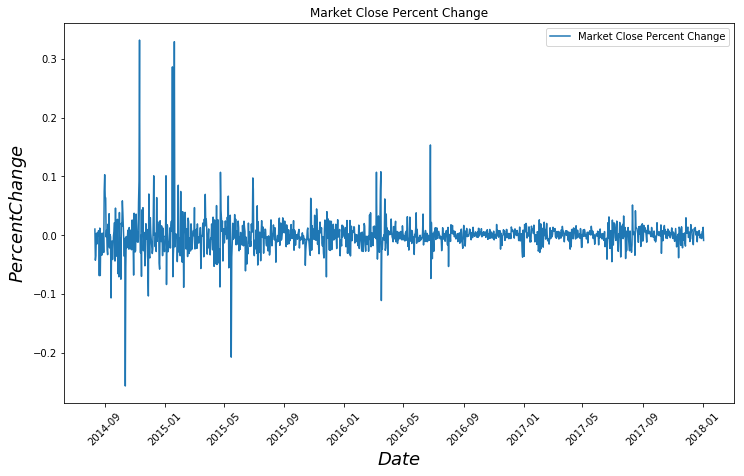

In [151]:
# Making plot of percent change for Market data
prices = df_Market.select_dtypes(exclude = (['object'])).pct_change()
prices.head()
prices.dropna(inplace=True)
plt.figure(figsize = (12,7))
plt.plot(prices[['close']],label='Market Close Percent Change')
plt.title(label = 'Market Close Percent Change')
plt.xlabel("$Date$", fontsize=18)
plt.ylabel("$Percent Change$", fontsize=18)
plt.xticks(rotation = 45)
plt.legend();

In [152]:
# Creating target variable
prices['Target'] = (prices[['close']] > 0).astype(int)
prices.head()

,close,high,low,open,sma_20day_close,sma_20day_high,sma_20day_low,sma_20day_open,upper_band_20day_close,upper_band_20day_high,upper_band_20day_low,upper_band_20day_open,lower_band_20day_close,lower_band_20day_high,lower_band_20day_low,lower_band_20day_open,CCI20,RSI_close,Target
2014-08-11,0.010349,-0.051947,0.033709,0.039379,0.001555,0.001117,0.004292,0.000551,0.004538,0.001223,0.003115,0.001404,-0.001685,0.000998,0.005573,-3.719854e-04,-0.225373,0.023939,1
2014-08-12,-0.042715,-0.016422,-0.027593,-0.017098,-0.000258,0.000996,0.001719,0.002586,-0.000105,-0.000153,0.000178,-0.004211,-0.000427,0.002276,0.003391,9.957609e-03,-1.073223,-0.109074,0
2014-08-13,-0.034992,-0.011973,-0.036039,0.006090,-0.003228,-0.003340,-0.002674,-0.000005,-0.000438,-0.008055,-0.002459,-0.000010,-0.006278,0.001893,-0.002907,-6.466668e-07,12.230488,-0.082600,0
2014-08-14,0.002820,-0.036758,0.002499,-0.059477,-0.003484,-0.003778,-0.002687,-0.003420,-0.003077,-0.000407,-0.003922,0.003134,-0.003932,-0.007483,-0.001351,-1.042755e-02,0.255779,0.008198,1
2014-08-15,-0.015245,0.019778,-0.032024,0.025721,-0.002652,-0.001908,-0.002452,-0.002829,0.001921,-0.000703,0.003976,-0.004016,-0.007685,-0.003241,-0.009390,-1.542929e-03,0.072818,-0.036914,0


In [153]:
# Train test split
X = prices
y = prices[['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train.head()

,close,high,low,open,sma_20day_close,sma_20day_high,sma_20day_low,sma_20day_open,upper_band_20day_close,upper_band_20day_high,upper_band_20day_low,upper_band_20day_open,lower_band_20day_close,lower_band_20day_high,lower_band_20day_low,lower_band_20day_open,CCI20,RSI_close,Target
2014-08-11,0.010349,-0.051947,0.033709,0.039379,0.001555,0.001117,0.004292,0.000551,0.004538,0.001223,0.003115,0.001404,-0.001685,0.000998,0.005573,-3.719854e-04,-0.225373,0.023939,1
2014-08-12,-0.042715,-0.016422,-0.027593,-0.017098,-0.000258,0.000996,0.001719,0.002586,-0.000105,-0.000153,0.000178,-0.004211,-0.000427,0.002276,0.003391,9.957609e-03,-1.073223,-0.109074,0
2014-08-13,-0.034992,-0.011973,-0.036039,0.006090,-0.003228,-0.003340,-0.002674,-0.000005,-0.000438,-0.008055,-0.002459,-0.000010,-0.006278,0.001893,-0.002907,-6.466668e-07,12.230488,-0.082600,0
2014-08-14,0.002820,-0.036758,0.002499,-0.059477,-0.003484,-0.003778,-0.002687,-0.003420,-0.003077,-0.000407,-0.003922,0.003134,-0.003932,-0.007483,-0.001351,-1.042755e-02,0.255779,0.008198,1
2014-08-15,-0.015245,0.019778,-0.032024,0.025721,-0.002652,-0.001908,-0.002452,-0.002829,0.001921,-0.000703,0.003976,-0.004016,-0.007685,-0.003241,-0.009390,-1.542929e-03,0.072818,-0.036914,0


In [154]:
# Timeseries Generator creating the train_sequences that will be used to train the GNU model and test_sequences that will be used to validate the model.
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
length = 5
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 5, 19)

In [155]:
# Setting up the model with a learning rate of 0.0001 and a dropout rate of 0.1
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
dropout_rate = .1 
model = Sequential()
model.add(GRU(64, input_shape=(length, 19), return_sequences=True))
model.add(GRU(32, return_sequences = False,
                dropout = dropout_rate,
                recurrent_dropout = dropout_rate
                ))

model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(lr=.0001), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=25, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


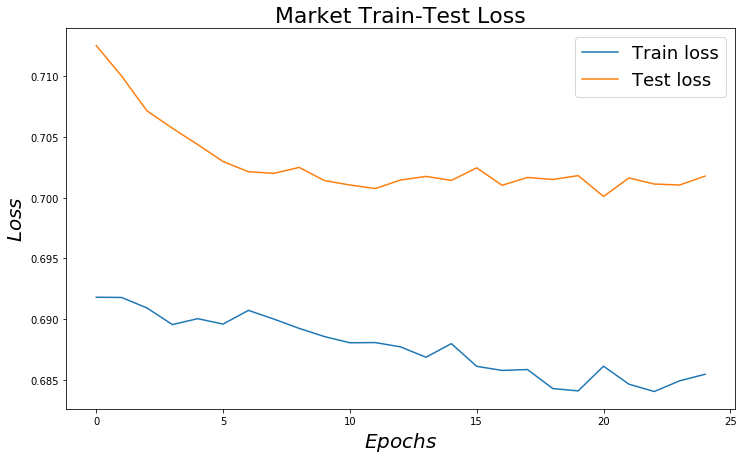

In [160]:
# Train-Test loss for Market
plt.figure(figsize = (12,7))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel("$Epochs$", fontsize=20)
plt.ylabel("$Loss$", fontsize=20)
plt.title(label = 'Market Train-Test Loss', fontsize=22)
plt.legend(fontsize=18);

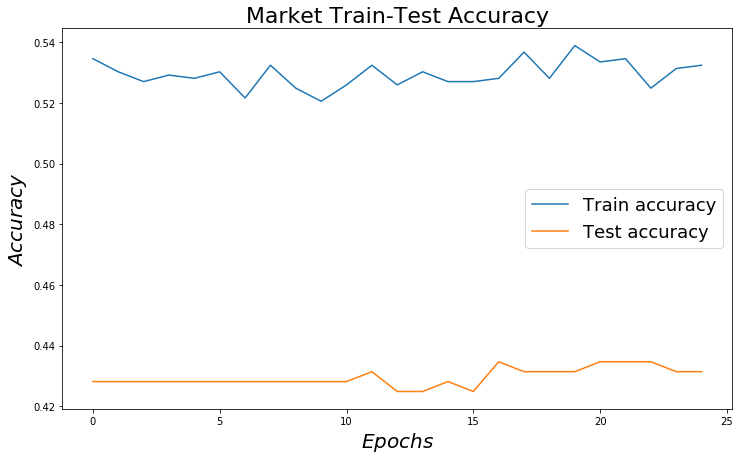

In [159]:
# Market Train-Test Accuracy
plt.figure(figsize = (12,7))
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.xlabel("$Epochs$", fontsize=20)
plt.ylabel("$Accuracy$", fontsize=20)
plt.title(label = 'Market Train-Test Accuracy', fontsize=22)
plt.legend(fontsize=18);

This model happens to produce no Negatives. Thus the predictions are either True Positives or False Positives.The true Positive rate is 168 to the false neganive rate of 133. This implies a good............................................................

In [161]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
pred_test = (model.predict_generator(test_sequences) > 0).astype(int)
metrics(y_test[:-5],pred_test)

True Positive: 176
True Negative: 0
False Positive: 130
False Negative: 0
Accuracy Rate: 0.5751633986928104
Misclassification Rate: 0.4248366013071896
Sensivitiy: 1.0
Specificity: 0.0
Precision: 0.5751633986928104
[[  0 130]
 [  0 176]]


In [163]:
pred_train = (model.predict_generator(train_sequences) > 0).astype(int)
metrics(y_train[:-5],pred_train)

True Positive: 432
True Negative: 0
False Positive: 494
False Negative: 0
Accuracy Rate: 0.46652267818574517
Misclassification Rate: 0.5334773218142548
Sensivitiy: 1.0
Specificity: 0.0
Precision: 0.46652267818574517
[[  0 494]
 [  0 432]]


### [RNN - AAPL](#Contents:)

In [161]:
# length of the moving average interval used throughout 
moving_avg = 20
df_data = []
for symb in Tickers:
    try:
        dfs = df[df['ticker'] == symb]
        dfs_object = dfs.select_dtypes(include=['object'])
        dfs = dfs.select_dtypes(exclude=['object'])
        # calculate the simple moving average
        sma_20day = dfs.rolling(window=moving_avg).mean()
        # calculate the standar deviation
        rstd_20day = dfs.rolling(window=moving_avg).std()
        # BBands 20 day
        upper_band_20day = sma_20day + 2 * rstd_20day
        upper_band_20day = upper_band_20day
        lower_band_20day = sma_20day - 2 * rstd_20day
        lower_band_20day = lower_band_20day
        # creating df_Market dataframe with all of the implemented features.
        data = pd.concat([dfs,sma_20day,upper_band_20day,lower_band_20day,CCI(dfs, moving_avg),talib.RSI(dfs['close'], moving_avg),dfs_object],axis = 1).dropna()
        data = data.dropna()
        # renaming the features to something more meaningful
        data.columns = [['close',  'high',   'low',  'open', 'sma_20day_close',  'sma_20day_high',   'sma_20day_low',  'sma_20day_open',
       'upper_band_20day_close',  'upper_band_20day_high',   'upper_band_20day_low',  'upper_band_20day_open', 'lower_band_20day_close',  'lower_band_20day_high',   'lower_band_20day_low',  'lower_band_20day_open',
       'CCI20',       'RSI_close',       'Date',       'ticker']]
        df_data.append(pd.DataFrame(data).set_index(pd.to_datetime(data.iloc[:,-2])))
    except:
        pass
df_clean = pd.concat(df_data)
df_clean.drop('Date',axis = 1,inplace = True)

In the following cell we take the clean data and extract only the apple symbols. Next we set the index and create a percent change dataframe of prices percent change. The plot below is that of percent change of stocks from the previous day to the current day plotted as a time series

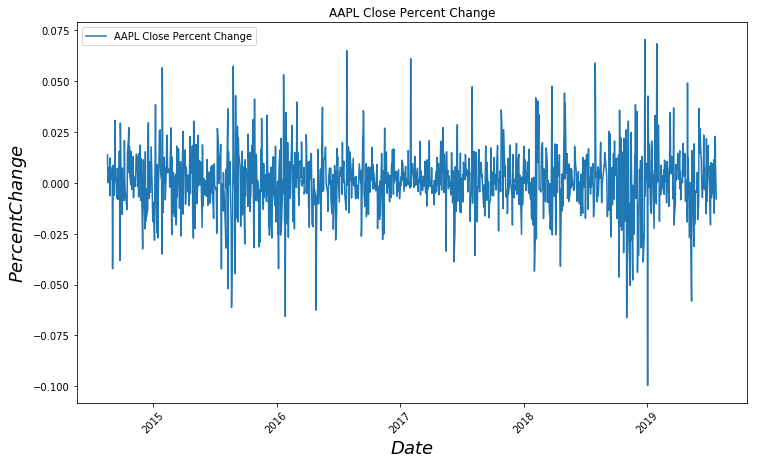

In [162]:
df_AAPL = df_clean.loc[df_clean.iloc[:,-1] == 'AAPL']
prices = df_AAPL.select_dtypes(exclude = (['object'])).pct_change()
prices.dropna(inplace=True)
plt.figure(figsize = (12,7))
plt.plot(prices[['close']],label='AAPL Close Percent Change')
plt.xlabel("$Date$", fontsize=18)
plt.ylabel("$Percent Change$", fontsize=18)
plt.title(label = 'AAPL Close Percent Change')
plt.xticks(rotation = 45)
plt.legend();

In [163]:
# We create a "Target" column which will become our y variable. This is essentially the dataframe we will use
prices['Target'] = (prices[['close']] > 0).astype(int)
prices.head()

,close,high,low,open,sma_20day_close,sma_20day_high,sma_20day_low,sma_20day_open,upper_band_20day_close,upper_band_20day_high,upper_band_20day_low,upper_band_20day_open,lower_band_20day_close,lower_band_20day_high,lower_band_20day_low,lower_band_20day_open,CCI20,RSI_close,Target
"(Date,)",,,,,,,,,,,,,,,,,,,
2014-08-19,0.013816,0.013183,0.013676,0.009341,0.003006,0.002980,0.002714,0.002453,0.006232,0.004888,0.005605,0.004034,-0.000424,0.000956,-0.000354,0.000771,0.326731,0.042135,1
2014-08-20,0.000398,0.004072,0.006343,0.010361,0.001744,0.001647,0.002488,0.002597,0.005488,0.005660,0.006619,0.006178,-0.002265,-0.002624,-0.001922,-0.001224,-0.073719,0.001135,1
2014-08-21,0.000099,-0.001484,0.001601,0.001294,0.001828,0.001854,0.001916,0.001821,0.004895,0.004792,0.005749,0.005396,-0.001480,-0.001298,-0.002212,-0.002020,-0.132507,0.000297,1
2014-08-22,0.007357,0.005251,0.000799,-0.002784,0.001876,0.001856,0.001840,0.001772,0.005660,0.005195,0.005115,0.004218,-0.002232,-0.001748,-0.001716,-0.000878,-0.011941,0.021986,1
2014-08-25,0.002171,0.006899,0.010879,0.014957,0.001293,0.001495,0.001930,0.002041,0.004399,0.005189,0.006443,0.006600,-0.002107,-0.002520,-0.003004,-0.002920,0.045177,0.006296,1


In [164]:
# Creating test train splits of the data above
X = prices
y = prices[['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
# Scaling is important here so this is the step where we scale.
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [165]:
# Timeseries Generator creating the train_sequences that will be used to train the GNU model and test_sequences that will be used to validate the model.
length = 5
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 5, 19)

In [166]:
dropout_rate = .1 
model = Sequential()
model.add(GRU(64, input_shape=(length, 19), return_sequences=True))
model.add(GRU(32, return_sequences = False,
                dropout = dropout_rate,
                recurrent_dropout = dropout_rate
                ))

model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(lr=.0001), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=25, verbose=0)

Below is the train-test loss for apple. It apears that the test loss underperforms the train loss thus overfitting is an assumption that can be made here. 

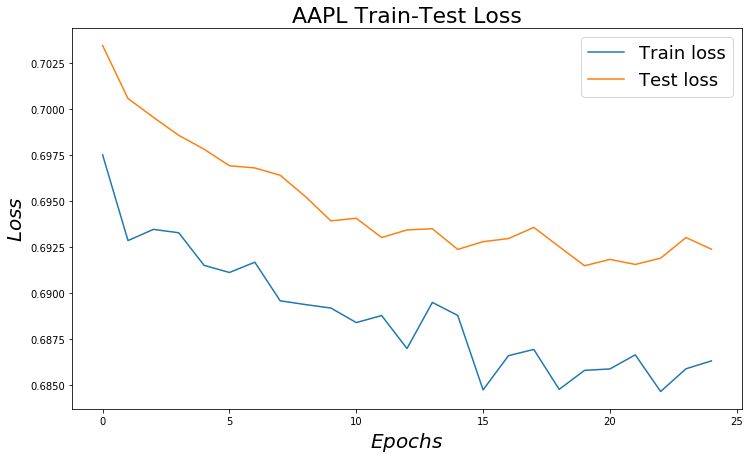

In [167]:
# Train-Test loss for Apple
plt.figure(figsize = (12,7))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel("$Epochs$", fontsize=20)
plt.ylabel("$Loss$", fontsize=20)
plt.title(label = 'AAPL Train-Test Loss', fontsize=22)
plt.legend(fontsize=18);

The accuracy of the train is better than that of the test. This implies that the model does better with the train set then new data. This is because as mentioned before, the train is overfit and thus strongly biased toward predicting those values correctly as opposed to new data that does not follow the same random trend.

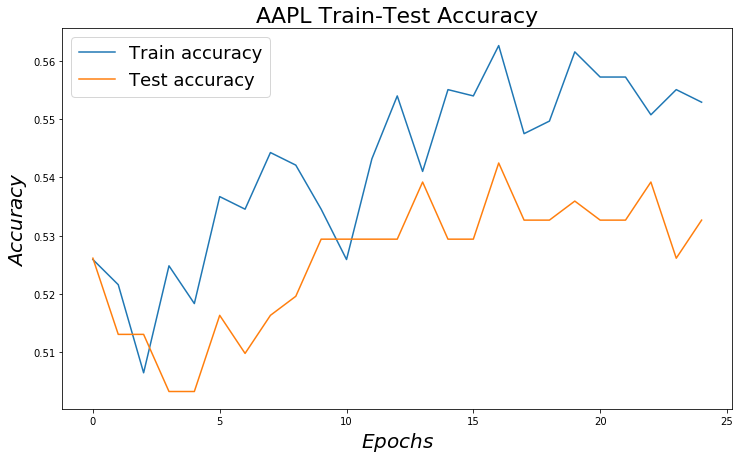

In [168]:
# Apple Train-Test Accuracy
plt.figure(figsize = (12,7))
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.xlabel("$Epochs$", fontsize=20)
plt.ylabel("$Accuracy$", fontsize=20)
plt.title(label = 'AAPL Train-Test Accuracy', fontsize=22)
plt.legend(fontsize=18);

Here we see that the accuracy of the test set is better than that of the train set. This is an indicator of a good model that can predict data that it hasnt seen yet better than data it has seen.

This model happens to produce no Negatives. Thus the predictions are either True Positives or False Positives.The true Positive rate is 168 to the false neganive rate of 133. This implies a good............................................................

In [169]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
pred = (model.predict_generator(test_sequences) > 0).astype(int)
metrics(y_test[:-5],pred)

True Positive: 167
True Negative: 0
False Positive: 139
False Negative: 0
Accuracy Rate: 0.545751633986928
Misclassification Rate: 0.45424836601307195
Sensivitiy: 1.0
Specificity: 0.0
Precision: 0.545751633986928
[[  0 139]
 [  0 167]]


In [170]:
pred = (model.predict_generator(train_sequences) > 0).astype(int)
metrics(y_train[:-5],pred)

True Positive: 477
True Negative: 0
False Positive: 449
False Negative: 0
Accuracy Rate: 0.5151187904967602
Misclassification Rate: 0.48488120950323976
Sensivitiy: 1.0
Specificity: 0.0
Precision: 0.5151187904967602
[[  0 449]
 [  0 477]]


### [RNN-GOOGL](#Contents:)

In [171]:
# extracting the ticks and numbers only from the dataframe
df_GOOGLE = df_clean.loc[df_clean.iloc[:,-1] == 'GOOGL']
df_GOOGLE_ticks = df_GOOGLE.select_dtypes(include = (['object']))
df_GOOGLE = df_GOOGLE.select_dtypes(exclude = (['object']))

In [172]:
# Renaming the columns
df_GOOGLE.columns = [['close',  'high',   'low',  'open', 'sma_20day_close',  'sma_20day_high',   'sma_20day_low',  'sma_20day_open',
       'upper_band_20day_close',  'upper_band_20day_high',   'upper_band_20day_low',  'upper_band_20day_open', 'lower_band_20day_close',  'lower_band_20day_high',   'lower_band_20day_low',  'lower_band_20day_open',
       'CCI20',       'RSI_close']]

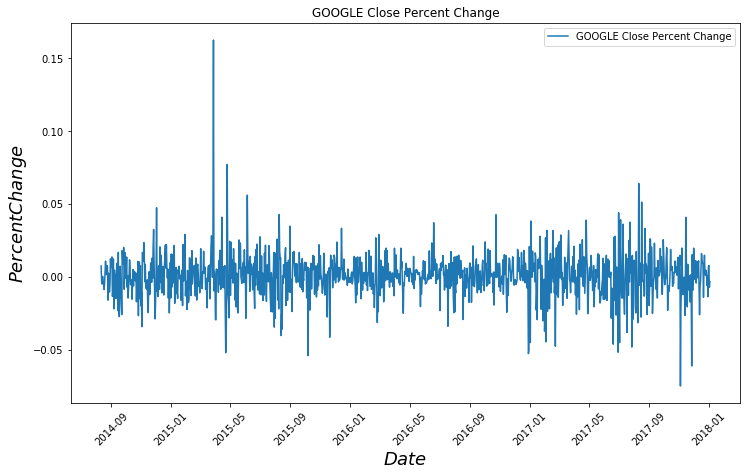

In [173]:
# converting to percent change then plotting to show the intermediate step before converting to target
df_GOOGLE = df_GOOGLE.set_index(Market[20:].index)
prices = df_GOOGLE.select_dtypes(exclude = (['object'])).pct_change()
prices.head()
prices.dropna(inplace=True)
plt.figure(figsize = (12,7))
plt.plot(prices[['close']],label='GOOGLE Close Percent Change')
plt.xlabel("$Date$", fontsize=18)
plt.ylabel("$Percent Change$", fontsize=18)
plt.title(label = 'GOOGLE Close Percent Change')
plt.xticks(rotation = 45)
plt.legend();

In [174]:
# Converting to target from percent change
prices['Target'] = (prices[['close']] > 0).astype(int) 
X = prices
y = prices[['Target']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
X_train.head()

,close,high,low,open,sma_20day_close,sma_20day_high,sma_20day_low,sma_20day_open,upper_band_20day_close,upper_band_20day_high,upper_band_20day_low,upper_band_20day_open,lower_band_20day_close,lower_band_20day_high,lower_band_20day_low,lower_band_20day_open,CCI20,RSI_close,Target
2014-08-11,0.007441,0.004638,0.013452,0.014461,-0.000551,-0.000938,-0.000414,-0.000350,-0.001929,-0.003222,-0.001456,-0.001054,0.000940,0.001522,0.000718,0.000409,1.149893,0.050065,1
2014-08-12,-0.002847,-0.001372,-0.002422,0.002283,-0.000835,-0.000852,-0.000718,-0.000435,-0.003095,-0.002939,-0.002684,-0.001501,0.001604,0.001385,0.001414,0.000715,-0.021864,-0.017776,0
2014-08-13,-0.005022,-0.002915,-0.003204,-0.003434,-0.000904,-0.001158,-0.000851,-0.000907,-0.003154,-0.004433,-0.003231,-0.003454,0.001511,0.002337,0.001716,0.001834,-0.098285,-0.031862,0
2014-08-14,0.000203,-0.000437,-0.002199,-0.002740,-0.000474,-0.000510,-0.000512,-0.000511,-0.001516,-0.001632,-0.001732,-0.001657,0.000641,0.000679,0.000798,0.000716,0.014224,0.001513,1
2014-08-15,-0.003325,0.000992,-0.000916,0.002528,-0.000723,-0.000469,-0.000287,-0.000255,-0.002362,-0.001621,-0.000895,-0.000856,0.001026,0.000750,0.000365,0.000387,-0.006979,-0.022702,0


In [175]:
# Scaling data
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [176]:
# Setting test train sequences
length = 5
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
batch_x.shape
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)

In [177]:
length = 5
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
batch_x.shape

(64, 5, 19)

Google RNN recurrent dropout = 0.1 and input shape of (5, 19)

In [179]:
dropout_rate = .1 
model = Sequential()
model.add(GRU(64, input_shape=(length, 19), return_sequences=True))
model.add(GRU(32, return_sequences = False,
                recurrent_dropout = dropout_rate
                ))

model.add(Dense(8, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(lr=.0001), loss='binary_crossentropy', metrics=['acc'])

history = model.fit_generator(train_sequences, validation_data=test_sequences, epochs=25, verbose=0)

Google Train-Test Loss plot. Here we see that the train is a bit overfit

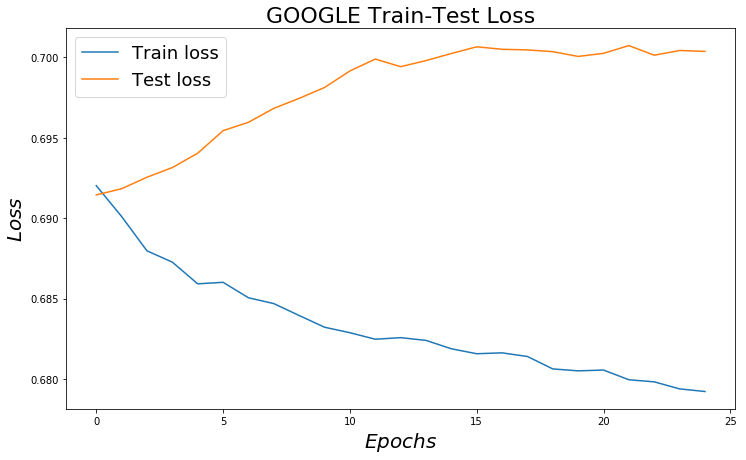

In [180]:
plt.figure(figsize = (12,7))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel("$Epochs$", fontsize=20)
plt.ylabel("$Loss$", fontsize=20)
plt.title(label = 'GOOGLE Train-Test Loss', fontsize=22 )
plt.legend(fontsize=18);

We see a better accuracy for the train data here in the Google Train-Test Accuracy plot.

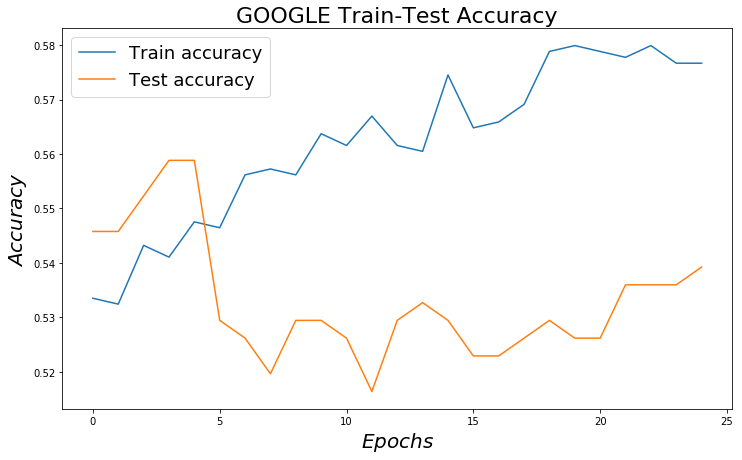

In [181]:
plt.figure(figsize = (12,7))
plt.plot(history.history['acc'], label='Train accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.xlabel("$Epochs$", fontsize=20)
plt.ylabel("$Accuracy$", fontsize=20)
plt.title(label = 'GOOGLE Train-Test Accuracy', fontsize=22)
plt.legend(fontsize=18);

With google we see that Accuracy for the train was all around better than the test which can be explained by the overfitting in the first place.

In [182]:
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
batch_x, batch_y = train_sequences[0]
test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
pred = (model.predict_generator(test_sequences) > 0).astype(int)
metrics(y_test[:-5],pred)

True Positive: 157
True Negative: 0
False Positive: 149
False Negative: 0
Accuracy Rate: 0.5130718954248366
Misclassification Rate: 0.48692810457516345
Sensivitiy: 1.0
Specificity: 0.0
Precision: 0.5130718954248366
[[  0 149]
 [  0 157]]


In [183]:
pred = (model.predict_generator(train_sequences) > 0).astype(int)
metrics(y_train[:-5],pred)

True Positive: 496
True Negative: 0
False Positive: 430
False Negative: 0
Accuracy Rate: 0.5356371490280778
Misclassification Rate: 0.4643628509719222
Sensivitiy: 1.0
Specificity: 0.0
Precision: 0.5356371490280778
[[  0 430]
 [  0 496]]


## [Clustering](#Contents:)

In this cell below we run the entire data set under an RNN model. The same model for all 372 of the tech stocks for which we have 5 years of data, and more precisely 1263 trading days. The dropout rate is 0.1 and the length of the time series generator is 5 days. Try except statements are implemented to bypass NAN errors that come up sporadically.

In [ ]:
dropout_rate = .1
length = 5
results = []
for tick in Tickers:
    temp = df_clean.loc[df_clean.iloc[:,-1] == tick]
    try:
        if temp.shape[0] == 1243: # Hard coding 1243 for 5 years worth of daily data
            # Specify frequency for data (this will be relevant later)!
            prices = temp.select_dtypes(exclude = (['object'])).pct_change()
            prices.dropna(inplace=True)
            
            # Convert prices that are percent change to binary target
            prices['Target'] = (prices[['close']] > 0).astype(int)
            X = prices.dropna()
            y = prices.iloc[:,-1]
            
            # Make train test split from target and X var.
            X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
            
            # Set polynomial features to 2
            poly = PolynomialFeatures(2)
            # Normalize features with stdard function
            X_train_sc = stdard(poly.fit_transform(X_train))
            X_test_sc = stdard(poly.transform(X_test.dropna(axis = 1)))
            
            # Set train and test sequences using length 5 and batch size 64 using timeseries generator.
            train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
            batch_x, batch_y = train_sequences[0]
            test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
            
            # Instantiating model and running 3 hidden layers with a dropout rate of 0.1
            model = Sequential()
            model.add(GRU(64, input_shape=(length, X_test_sc.shape[1]), return_sequences=True))
            model.add(GRU(32, return_sequences = False,
                recurrent_dropout = dropout_rate
                )
            model.add(Dense(8, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer=Adam(lr=.01), loss='binary_crossentropy', metrics=['acc'])
            model.fit_generator(train_sequences, validation_data=test_sequences, epochs=25, verbose=0)
            
            train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
            batch_x, batch_y = train_sequences[0]
            test_sequences = TimeseriesGenerator(X_test_sc, y_test, length=length, batch_size=64)
            
            pred = (model.predict_generator(test_sequences) > 0).astype(int)
            pred_train = (model.predict_generator(train_sequences) > 0).astype(int)
            
            # Appending to results list tick, accuracy of train and accuracy of preds
            results.append([tick,metricsacc(y_train[:-5],pred_train),metricsacc(y_test[:-5],pred)])
                      
    except:
        pass

Output is saved and stored locally

In [385]:
# Storing results as Results in working directory for later use
# # pd.DataFrame(results).to_csv('../data/Results.csv')
# Renaming columns to ticker, true and pred
results = pd.read_csv('../data/Results.csv').drop('Unnamed: 0',axis = 1)
results = pd.DataFrame(results)
results.columns = ['ticker', 'train', 'test']
# We prepare our X matrix for scaling
X = results.loc[:, ['train', 'test']]
sc = StandardScaler()
X_sc = sc.fit_transform(X)
results.head()

,ticker,train,test
0,TWOU,0.548596,0.500000
1,DDD,0.473002,0.519608
2,JOBS,0.529158,0.519608
3,WUBA,0.491361,0.496732
4,EGHT,0.490281,0.575163


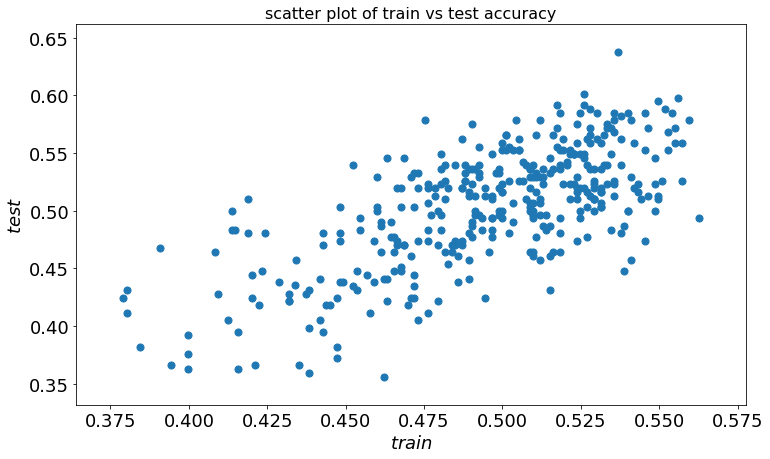

In [386]:
# Ploting the scatter
ax = results.plot(kind="scatter", x="train", y="test", figsize=(12,7), s=50)
plt.xlabel("$train$", fontsize=18)
plt.ylabel("$test$", fontsize=18)
plt.title(label = 'scatter plot of train vs test accuracy', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=18)

Below we iterate through 20 cluster number combinations in order to determine the optimal number to use in the analysis. As one can see, 4 clusters is the optimal number here given that the goal is to maximize the silhouette and minimize the inertia while at the same time also decreasing the number of clusters.

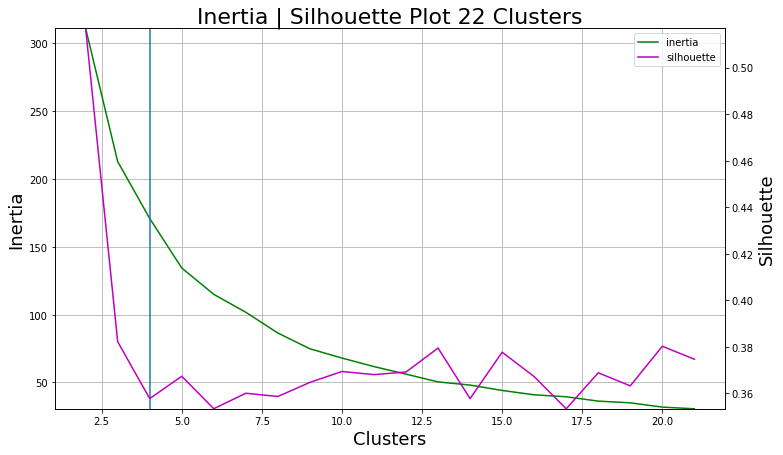

In [387]:
scores = []
for k in range(2, 22):
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
axis = ax.plot(score_df.k, score_df.inertia,'g', label = 'inertia')
plt.axvline(x=4)
ax2 = ax.twinx()
axis2 = ax2.plot(score_df.k, score_df.silhouette,'m',label = 'silhouette')
axes = axis+axis2
axe = [axy.get_label() for axy in axes]
ax.legend(axes, axe, loc=0)
ax.grid()
ax.set_xlabel("Clusters", fontsize = 18)
ax.set_title("Inertia | Silhouette Plot 22 Clusters", fontsize = 22)
ax.set_ylabel("Inertia", fontsize = 18)
ax2.set_ylabel("Silhouette", fontsize = 18)
ax2.set_ylim(min(score_df.silhouette),max(score_df.silhouette))
ax.set_ylim(min(score_df.inertia),max(score_df.inertia))
plt.show()

Creading a new column of the cluster numbers.

In [388]:
# Preparing our X matrix
X = results.loc[:, ['train', 'test']]
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# Fit a k-means clustering model
km = KMeans(n_clusters=4, random_state=42)
km.fit(X_sc)
# attach predicted cluster to original points
results['cluster'] = km.labels_
results.head()

,ticker,train,test,cluster
0,TWOU,0.548596,0.500000,2
1,DDD,0.473002,0.519608,1
2,JOBS,0.529158,0.519608,2
3,WUBA,0.491361,0.496732,1
4,EGHT,0.490281,0.575163,3


In [389]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(
    sc.inverse_transform(km.cluster_centers_),
    columns=["Train", "Test"]
)
centroids

,Train,Test
0,0.437053,0.425267
1,0.481469,0.501591
2,0.524668,0.503990
3,0.524505,0.561848


<Figure size 864x504 with 0 Axes>

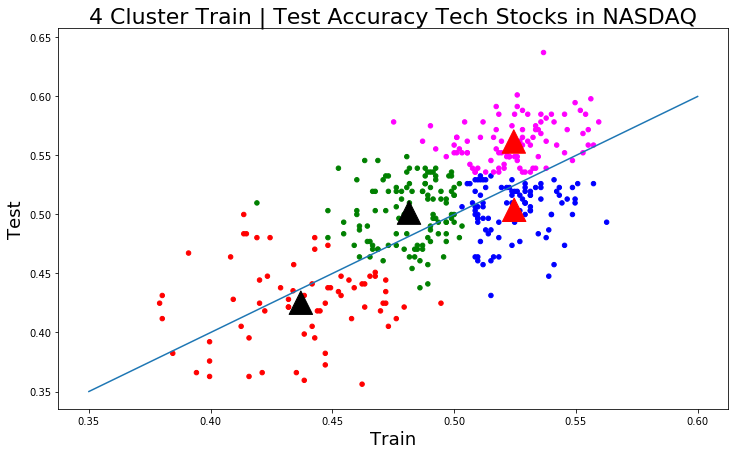

In [390]:
plt.figure(figsize=(12,7))

## Plot scatter by cluster / color, and centroids
colors = ["red", "green", "blue", "magenta"]
results['color'] = results['cluster'].map(lambda p: colors[p])

ax = results.plot(    
    kind="scatter", 
    x="train", y="test",
    figsize=(12,7),
    c = results['color']
)

ax.set_ylabel("Test", fontsize = 18)
ax.set_xlabel("Train", fontsize = 18)
ax.set_title("4 Cluster Train | Test Accuracy Tech Stocks in NASDAQ", fontsize = 22)



centroids.plot(
    kind="scatter", 
    x="Train", y="Test", 
    marker="^", c=["k", "k", "r",'r'], s=550,
    ax=ax
)

# plot 1 to 1 line to see high performing moidels.
ident = [0.35, 0.6]

plt.plot(ident,ident);

In [391]:
ticker_data = pd.read_csv('../data/companylist.csv')
data_high_performing = pd.merge(pd.DataFrame(results[results['color'] == 'magenta']),pd.DataFrame(ticker_data),left_on='ticker',right_on='Symbol')
data_low_performing = pd.merge(pd.DataFrame(results[results['color'] == 'blue']),pd.DataFrame(ticker_data),left_on='ticker',right_on='Symbol')

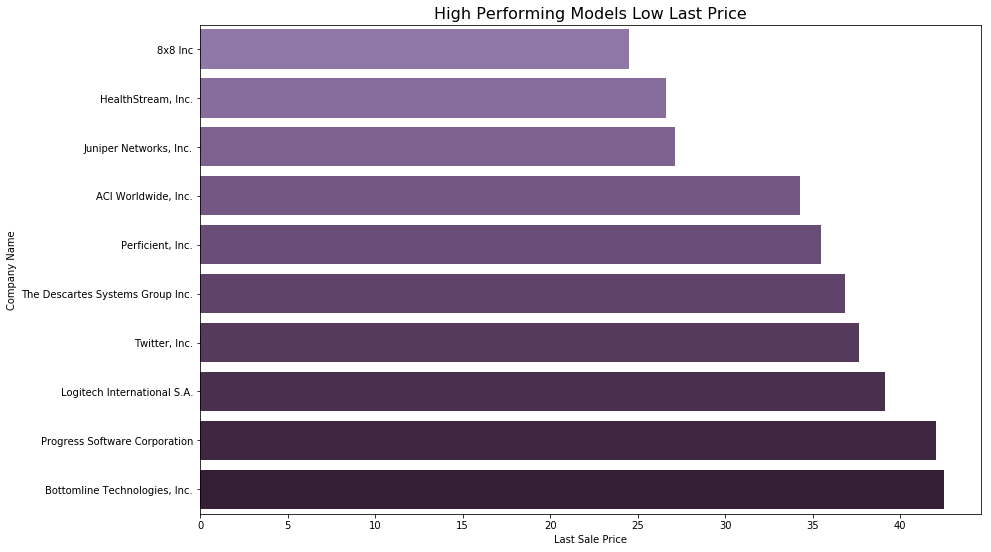

In [392]:
#Code for plotting the highest occurance of cords in the Vintage Subreddit
plt.figure(figsize = (14,9))
Words = data_high_performing.sort_values(by = 'LastSale').head(10)
sns.barplot(y = 'Name', x = 'LastSale', data = Words, palette = "ch:-2.5,-.2,light=.5")
plt.title('High Performing Models Low Last Price', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(rotation = 0);

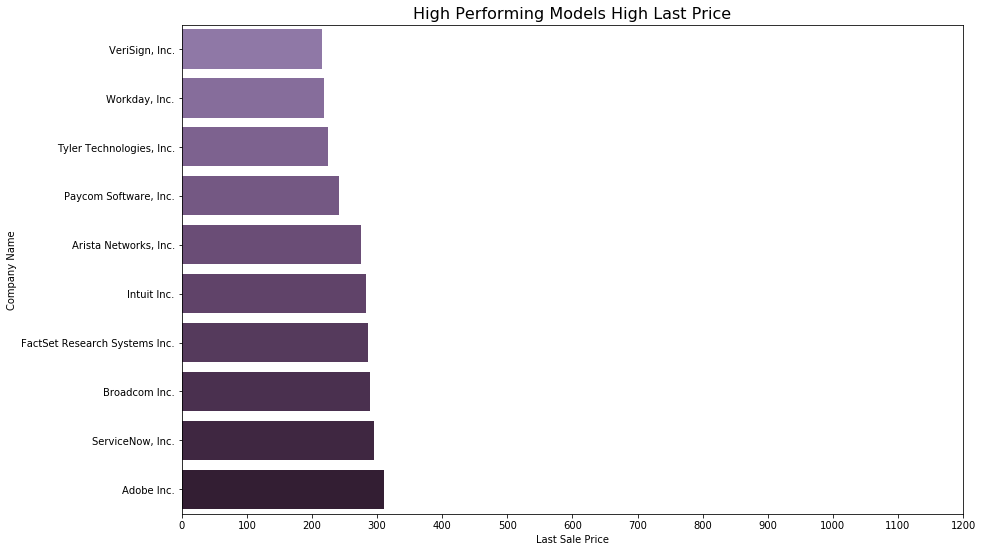

In [393]:
#Code for plotting the highest occurance of cords in the Vintage Subreddit
plt.figure(figsize = (14,9))
Words = data_high_performing.sort_values(by = 'LastSale').tail(10)
sns.barplot(y = 'Name', x = 'LastSale', data = Words, palette = "ch:-2.5,-.2,light=.5")
plt.title('High Performing Models High Last Price', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(range(0,1300,100));

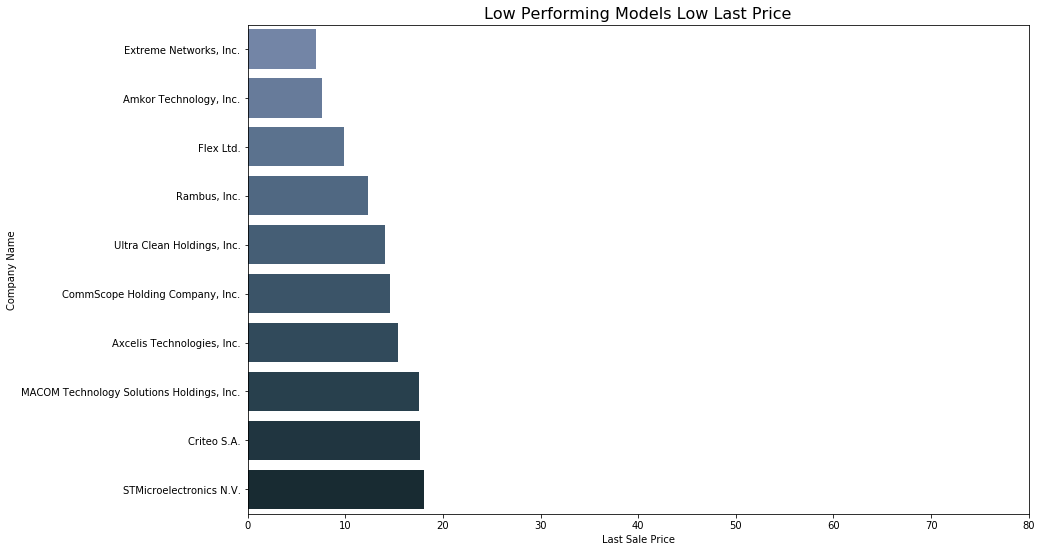

In [394]:
#Code for plotting the highest occurance of cords in the Vintage Subreddit
plt.figure(figsize = (14,9))
Words = data_low_performing.sort_values(by = 'LastSale').head(10)
sns.barplot(y = 'Name', x = 'LastSale', data = Words, palette = "ch:2.5,.2,light=.5")
plt.title('Low Performing Models Low Last Price', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(range(0,90,10));

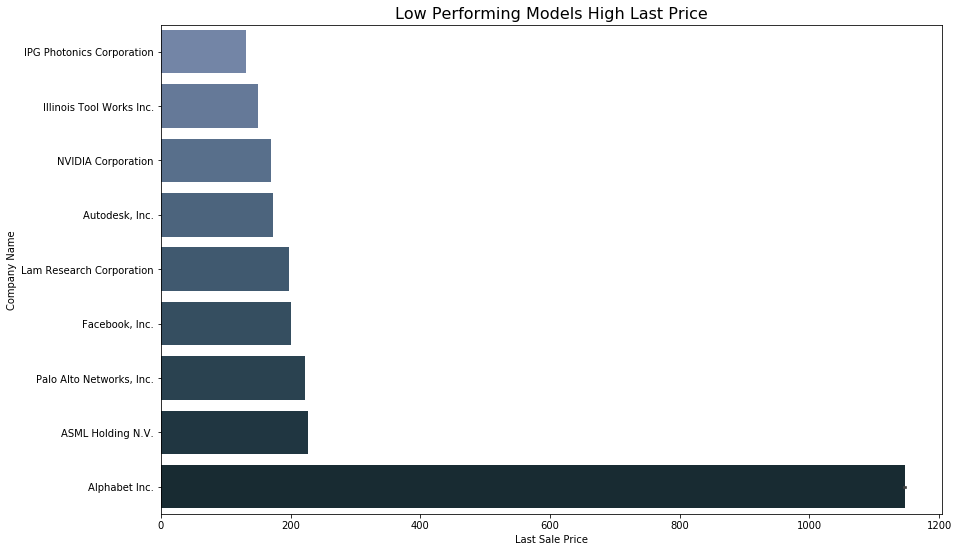

In [395]:
#Code for plotting the highest occurance of cords in the Vintage Subreddit
plt.figure(figsize = (14,9))
Words = data_low_performing.sort_values(by = 'LastSale').tail(10)
sns.barplot(y = 'Name', x = 'LastSale', data = Words, palette = "ch:2.5,.2,light=.5")
plt.title('Low Performing Models High Last Price', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(rotation = 0);

In [396]:
# Preparing our X matrix
X = results.loc[:, ['train', 'test']]
sc = StandardScaler()
X_sc = sc.fit_transform(X)
# Fit a k-means clustering model
km = KMeans(n_clusters=11, random_state=42)
km.fit(X_sc)
# attach predicted cluster to original points
results['cluster'] = km.labels_
results.head()

,ticker,train,test,cluster,color
0,TWOU,0.548596,0.500000,9,blue
1,DDD,0.473002,0.519608,6,green
2,JOBS,0.529158,0.519608,9,blue
3,WUBA,0.491361,0.496732,2,green
4,EGHT,0.490281,0.575163,1,magenta


In [397]:
## Create a dataframe for cluster_centers (centroids)
centroids = pd.DataFrame(
    sc.inverse_transform(km.cluster_centers_),
    columns=["Train", "Test"]
)
centroids

,Train,Test
0,0.421089,0.471989
1,0.511675,0.548465
2,0.501631,0.503824
3,0.438985,0.376471
4,0.457907,0.430914
5,0.522021,0.471725
6,0.480535,0.530556
7,0.538286,0.575241
8,0.399734,0.401458
9,0.534038,0.517345


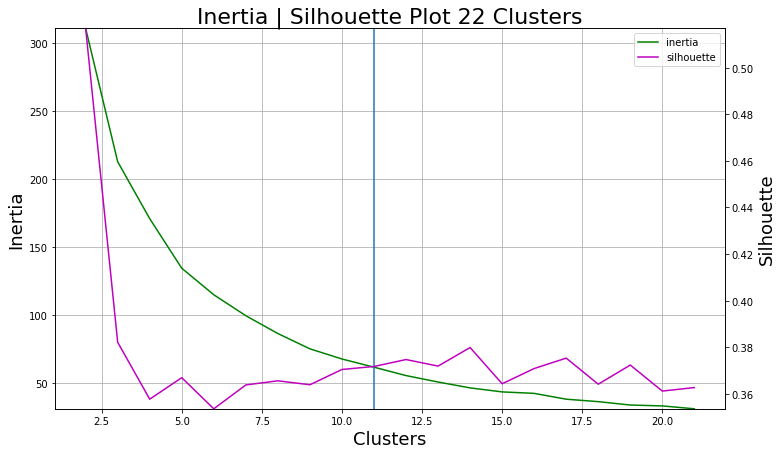

In [398]:
scores = []
for k in range(2, 22):
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(111)
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']
axis = ax.plot(score_df.k, score_df.inertia,'g', label = 'inertia')
plt.axvline(x=11)
ax2 = ax.twinx()
axis2 = ax2.plot(score_df.k, score_df.silhouette,'m',label = 'silhouette')
axes = axis+axis2
axe = [axy.get_label() for axy in axes]
ax.legend(axes, axe, loc=0)
ax.grid()
ax.set_xlabel("Clusters", fontsize = 18)
ax.set_title("Inertia | Silhouette Plot 22 Clusters", fontsize = 22)
ax.set_ylabel("Inertia", fontsize = 18)
ax2.set_ylabel("Silhouette", fontsize = 18)
ax2.set_ylim(min(score_df.silhouette),max(score_df.silhouette))
ax.set_ylim(min(score_df.inertia),max(score_df.inertia))
plt.show()

<Figure size 864x504 with 0 Axes>

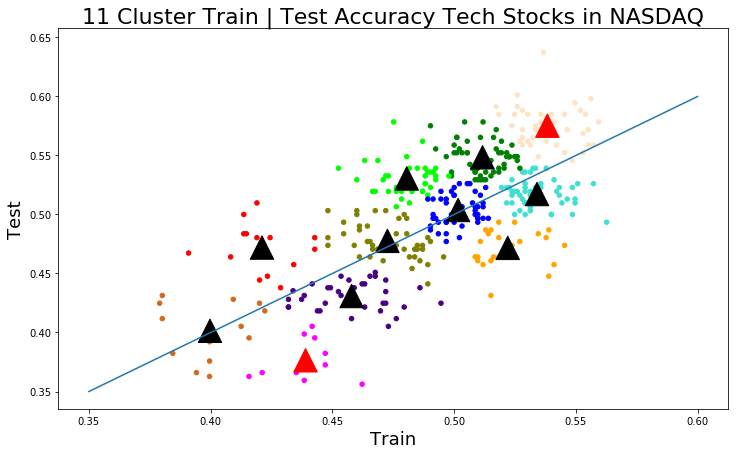

In [399]:
plt.figure(figsize=(12,7))

## Plot scatter by cluster / color, and centroids
colors = ["red", "green", "blue", "magenta","indigo","orange","lime","bisque","chocolate","turquoise","olive"]
results['color'] = results['cluster'].map(lambda p: colors[p])

ax = results.plot(    
    kind="scatter", 
    x="train", y="test",
    figsize=(12,7),
    c = results['color']
)

ax.set_ylabel("Test", fontsize = 18)
ax.set_xlabel("Train", fontsize = 18)
ax.set_title("11 Cluster Train | Test Accuracy Tech Stocks in NASDAQ", fontsize = 22)



centroids.plot(
    kind="scatter", 
    x="Train", y="Test", 
    marker="^", c=["k","k","k","r","k","k","k","r","k","k","k"], s=550,
    ax=ax
)

# plot 1 to 1 line to see high performing moidels.
ident = [0.35, 0.6]

plt.plot(ident,ident);

In [401]:
# here we collect the high performing and low performing clusters
ticker_data = pd.read_csv('../data/companylist.csv')
data_high_performing = pd.merge(pd.DataFrame(results[results['color'] == 'bisque']),pd.DataFrame(ticker_data),left_on='ticker',right_on='Symbol')
data_low_performing = pd.merge(pd.DataFrame(results[results['color'] == 'magenta']),pd.DataFrame(ticker_data),left_on='ticker',right_on='Symbol')

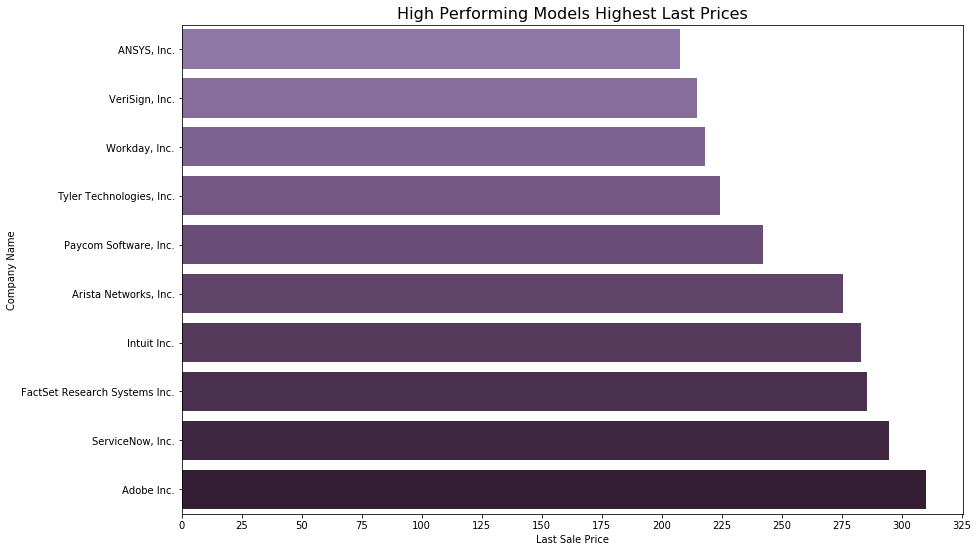

In [413]:
#Code for plotting the highest performing models top last price
plt.figure(figsize = (14,9))
Words = data_high_performing.sort_values(by = 'LastSale').tail(10)
sns.barplot(y = 'Name', x = 'LastSale', data = Words, palette = "ch:-2.5,-.2,light=.5")
plt.title('High Performing Models Highest Last Prices', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(range(0,350,25));

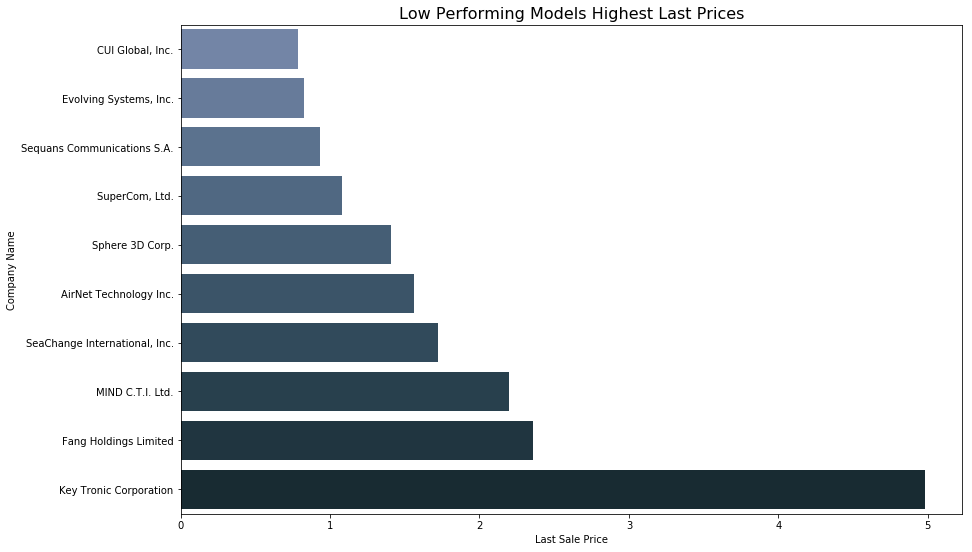

In [411]:
#Code for plotting the lowest performing models top last price
plt.figure(figsize = (14,9))
Words = data_low_performing.sort_values(by = 'LastSale').tail(10)
sns.barplot(y = 'Name', x = 'LastSale', data = Words, palette = "ch:2.5,.2,light=.5")
plt.title('Low Performing Models Highest Last Prices', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(range(0,6,1));

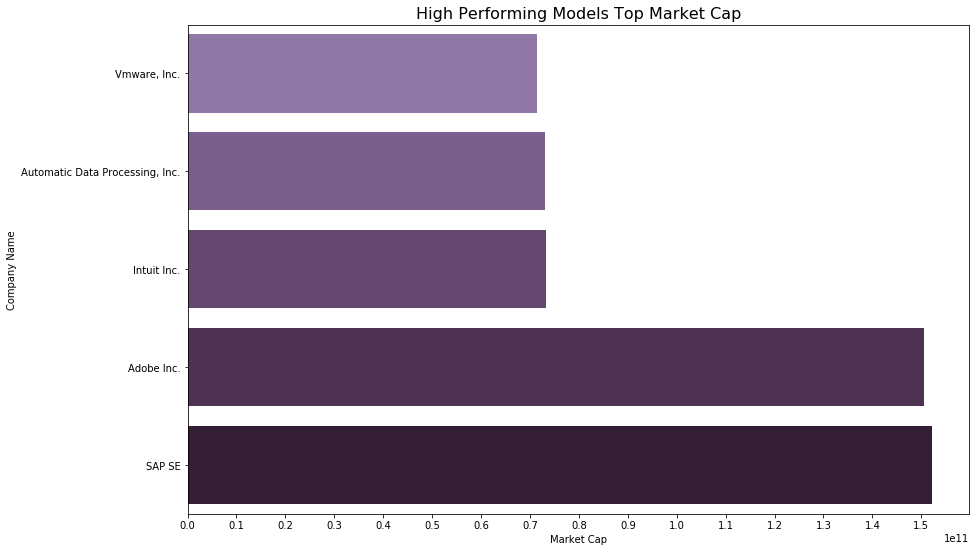

In [427]:
#Code for plotting the highest performing models top market cap
plt.figure(figsize = (14,9))
Words = data_high_performing.sort_values(by = 'MarketCap').tail(5)
sns.barplot(y = 'Name', x = 'MarketCap', data = Words, palette = "ch:-2.5,-.2,light=.5")
plt.title('High Performing Models Top Market Cap', fontsize = 16)
plt.xlabel('Market Cap')
plt.ylabel('Company Name')
plt.xticks(range(0,160_000_000_000,10_000_000_000));

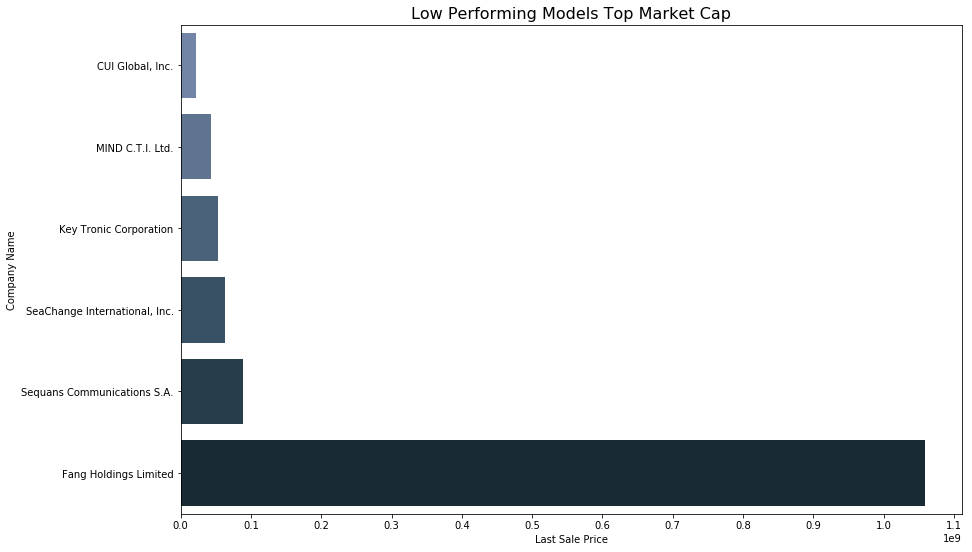

In [428]:
#Code for plotting the lowest performing models top market cap
plt.figure(figsize = (14,9))
Words = data_low_performing.sort_values(by = 'MarketCap').tail(6)
sns.barplot(y = 'Name', x = 'MarketCap', data = Words, palette = "ch:2.5,.2,light=.5")
plt.title('Low Performing Models Top Market Cap', fontsize = 16)
plt.xlabel('Last Sale Price')
plt.ylabel('Company Name')
plt.xticks(range(0,1200000000,100000000));

## [Executive Summary](#Contents:)

At the start of this project we were certain we would build a superior model to anything on the market with crude tools and a wild imagination. Come to find that it is not really that easy. Using SARIMAX we were able to come up with am okay but not great start. After venturing down this rabbit hole, an RNN was used. These models appear to be better according to the train test accuracy. 

Following this better guess we decided to run all 372 stocks in the same RNN model. After doing so we clustered the results to determine high accuracy clusters. Using 4 clusters we were unable to determine anything significant however after using 11 clusters we were able to determine that high performing models tend to have a larger last price and much more market cap while the exact opposite is true for low accuracy models. 

Thus if one was to use RNN to predict stocks and gamble on the market, doing so with large companies would likely yield better results.

For future work, we would like to dig into the different clusters. Really dig into other indicators like beta scores, P/E ratio, other indicators and studies which we can implement to see if we can rationally come up with a reason for why or what makes up a good predicting stock model.

## [Limitations](#Contents:)

As we conclude this analysis, it is important to notice how computationally heavy this type of work can be. A larger computer should be used next time as well as implementing Bayesian Statistics where we can infer the probability of a binary outcome based on a previous probability prediction.

## [Citations](#Contents:)

https://pypi.org/project/iexfinance/

https://github.com/addisonlynch/iexfinance

https://iexcloud.io/console/

https://www.programcreek.com/python/example/92311/talib.CCI

https://www.nasdaq.com/screening/companies-by-industry.aspx?industry=Technology

https://git.generalassemb.ly/DSI-US-8/9.03-9.04-lesson-ARIMA